# Sandbox: DEM / Shadow / Reflectance / Image

This notebook creates a synthetic DEM, computes the fast scan-line shadow map (sun-at-infinity), computes the Hapke reflectance map and the camera image using the project's renderer, and plots the results for quick inspection.


In [2]:
# Imports and parameters
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import math as math
import torch.nn.functional as F

# Project utilities (same folder)
from master.data_sim.generator import _generate_synthetic_dem, _render_single_image
from master.render.dem_utils import DEM
from master.render.hapke_model import HapkeModel
from master.render.camera import Camera
from master.render.renderer import Renderer
from scipy.ndimage import label

# Example parameters (tweak as needed)
DEM_SIZE = 512
IMAGE_W = 128
IMAGE_H = 128
SUN_AZ = 90.0   # degrees
SUN_EL = 20.0   # degrees
CAM_AZ = 180.0  # degrees
CAM_EL = 80.0   # degrees
CAM_DIST = 2000.0


print('Ready — imports OK')


Ready — imports OK


DEM shape: (512, 512)


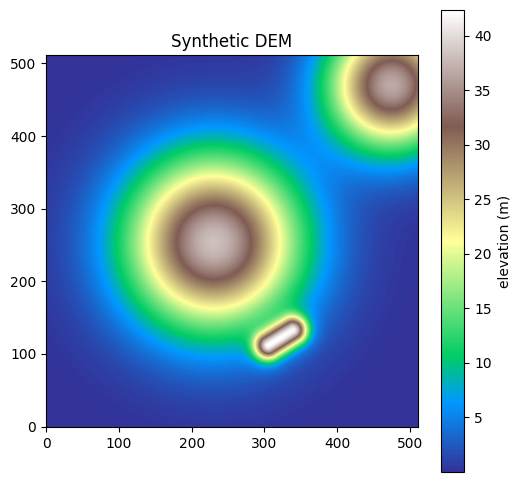

In [34]:
# Create a synthetic DEM and show it
# We use the project's generator so the DEM looks like what training uses
np.random.seed(20)
dem_size = 512
n_craters = 0
n_ridges = 1
n_hills = 2
crater_depth_range = (20, 50)
crater_radius_range = (30, 80)
ridge_height_range = (30, 40)
ridge_length_range = (0.05, 0.1)
ridge_width_range = (0.05, 0.1)
hill_height_range = (30, 40)
hill_sigma_range = (0.5, 0.1)

dem = _generate_synthetic_dem(size=dem_size, 
                                    n_craters=n_craters, 
                                    n_ridges=n_ridges, 
                                    n_hills=n_hills,
                                    crater_depth_range=crater_depth_range,
                                    crater_radius_range=crater_radius_range,
                                    ridge_height_range=ridge_height_range,
                                    ridge_length_range=ridge_length_range,
                                    ridge_width_range=ridge_width_range,
                                    hill_height_range=hill_height_range,
                                    hill_sigma_range=hill_sigma_range)
print('DEM shape:', dem.shape)

plt.figure(figsize=(6,6))
plt.imshow(dem, cmap='terrain', origin='lower')
plt.title('Synthetic DEM')
plt.colorbar(label='elevation (m)')
plt.show()


In [47]:
def compute_shadow_map(dem_array, sun_az_deg, sun_el_deg, cellsize=1, clean=True, neighborhood_size=6, neighborhood_threshold=0.5):
    """
    Torch-based scan-line shadow map (sun at infinity) returning the
    backward (bottom->top) scan result as the final lit map (1=lit, 0=shadow).

    This version runs at the DEM's native resolution and does not perform
    any internal upsampling/downsamping.

    Cleaning options:
      - If `clean` is True, a pure-Torch neighborhood majority filter is applied
        with a window of size `neighborhood_size`. A pixel is lit if at least
        `neighborhood_threshold` fraction of the window is lit.

    Parameters:
      dem_array: 2D numpy array or torch tensor
      sun_az_deg, sun_el_deg: sun geometry in degrees
      cellsize: size of DEM cells (meters)
      clean: whether to apply neighborhood cleaning
      neighborhood_size: odd int fallback window size (pure-Torch)
      neighborhood_threshold: fraction in (0,1] of lit pixels in window to consider lit
    """
    if torch.is_tensor(dem_array):
        dem_t = dem_array
    else:
        dem_t = torch.from_numpy(np.array(dem_array)).to(dtype=torch.float32)

    if dem_t.dim() != 2:
        raise ValueError('dem_array must be 2D')

    device = dem_t.device
    dem_t = dem_t.to(dtype=torch.float32, device=device)
    H, W = dem_t.shape

    # pad to larger square (diagonal) to avoid clipping on rotation
    diag = int(math.ceil(math.hypot(H, W)))
    pad_h = max(0, (diag - H) // 2 + 2)  # small extra margin
    pad_w = max(0, (diag - W) // 2 + 2)

    dem_b = dem_t.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    if pad_h > 0 or pad_w > 0:
        dem_b = F.pad(dem_b, (pad_w, pad_w, pad_h, pad_h), mode='constant', value=0.0)

    cellsize_up = cellsize

    H_p, W_p = dem_b.shape[-2], dem_b.shape[-1]

    # Rotate so sun az points along image rows (clockwise rotation by az)
    az = float(sun_az_deg)
    theta = math.radians(-az)
    cos_t = math.cos(theta); sin_t = math.sin(theta)
    theta_mat = torch.tensor([[[cos_t, -sin_t, 0.0], [sin_t, cos_t, 0.0]]], dtype=torch.float32, device=device)

    grid = F.affine_grid(theta_mat, dem_b.size(), align_corners=False)
    dem_rot = F.grid_sample(dem_b, grid, mode='nearest', padding_mode='zeros', align_corners=False)

    # Mask of valid (non-padded) pixels after rotation
    ones = torch.ones_like(dem_b)
    mask_rot = F.grid_sample(ones, grid, mode='nearest', padding_mode='zeros', align_corners=False)

    # Transformed field T = elevation - (row_index * cellsize_up * tan(el))
    el_rad = math.radians(sun_el_deg)
    tan_el = math.tan(el_rad)
    rows = torch.arange(H_p, dtype=torch.float32, device=device).view(1, 1, H_p, 1) * cellsize_up
    T = dem_rot - rows * tan_el  # shape (1,1,H_p,W_p)

    # Mark padding as -inf so it never occludes
    neg_inf = -float('inf')
    T = torch.where(mask_rot == 0, torch.tensor(neg_inf, device=device, dtype=T.dtype), T)

    # Explicit backward row-wise scan (bottom -> top)
    lit_rot = torch.zeros_like(T, dtype=torch.bool)
    prev_max = torch.full((1, 1, 1, W_p), neg_inf, device=device, dtype=T.dtype)
    for r in range(H_p-1, -1, -1):
        cur = T[:, :, r:r+1, :]
        is_lit = cur >= prev_max
        lit_rot[:, :, r:r+1, :] = is_lit
        prev_max = torch.maximum(prev_max, cur)

    # Rotate lit map back to original orientation
    lit_rot_f = lit_rot.float()
    theta_inv = math.radians(az)
    cos_i = math.cos(theta_inv); sin_i = math.sin(theta_inv)
    theta_mat_inv = torch.tensor([[[cos_i, -sin_i, 0.0], [sin_i, cos_i, 0.0]]], dtype=torch.float32, device=device)
    grid_inv = F.affine_grid(theta_mat_inv, dem_b.size(), align_corners=False)

    # inverse-sample lit map and reproject validity mask
    shadow_b = F.grid_sample(lit_rot_f, grid_inv, mode='nearest', padding_mode='zeros', align_corners=False)
    mask_back = F.grid_sample(mask_rot.float(), grid_inv, mode='nearest', padding_mode='zeros', align_corners=False)

    # crop center region back to original DEM size
    start_h = pad_h
    end_h = start_h + H
    start_w = pad_w
    end_w = start_w + W
    shadow_cropped = shadow_b[:, :, start_h:end_h, start_w:end_w]
    mask_cropped = mask_back[:, :, start_h:end_h, start_w:end_w]

    # remove padding-origin pixels
    shadow_cropped = shadow_cropped * (mask_cropped > 0.5).float()

    # Apply a 3x3 majority smoothing (neighborhood cleaning) if requested
    if clean:
        k = max(3, int(neighborhood_size) // 2 * 2 + 1)  # ensure odd and >=3
        pad = k // 2
        kern = torch.ones((1, 1, k, k), device=shadow_cropped.device, dtype=shadow_cropped.dtype)
        sums = F.conv2d(shadow_cropped, kern, padding=pad)
        thresh = float(k * k) * float(max(0.0, min(1.0, neighborhood_threshold)))
        shadow_clean = (sums >= thresh).float()
        shadow_map_t = shadow_clean.squeeze(0).squeeze(0).to(dtype=torch.uint8)
    else:
        shadow_map_t = shadow_cropped.squeeze(0).squeeze(0).to(dtype=torch.uint8)

    if shadow_map_t.shape != dem_t.shape:
        raise ValueError(f"Shadow map shape {tuple(shadow_map_t.shape)} does not match DEM shape {tuple(dem_t.shape)}")

    return shadow_map_t.cpu().numpy()


In [ ]:
def compute_shadow_map_new(dem_array, sun_az_deg, sun_el_deg, device=None, cellsize=1):
    """
    Optimized torch-based scan-line shadow map (sun at infinity).
    Returns lit map (1=lit, 0=shadow) as boolean tensor.
    
    Algorithm:
    1. Rotate DEM to align sun azimuth with image rows
    2. Compute transformed elevation field T = elevation - row * cellsize * tan(sun_el)
    3. Use cummax to find horizon from bottom->top (backward scan)
    4. Rotate result back to original orientation
    
    Args:
        dem_array: 2D numpy array or torch tensor (elevation map)
        sun_az_deg: Sun azimuth in degrees
        sun_el_deg: Sun elevation in degrees
        device: torch device (defaults to input tensor device or CPU)
        cellsize: DEM cell size in meters
    
    Returns:
        Boolean tensor where True=lit, False=shadow
    """
    # Convert input to torch tensor and handle device placement
    if torch.is_tensor(dem_array):
        dem_t = dem_array.to(dtype=torch.float32)
        device = device or dem_array.device
    else:
        device = device or torch.device('cpu')
        dem_t = torch.as_tensor(dem_array, dtype=torch.float32, device=device)

    H, W = dem_t.shape

    # Pad to diagonal size to prevent rotation clipping
    diag = int(math.ceil(math.hypot(H, W))) + 4  # +4 for margin
    pad = (diag - H) // 2, (diag - W) // 2
    
    dem_b = dem_t.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
    dem_b = F.pad(dem_b, (pad[1], pad[1], pad[0], pad[0]), mode='constant', value=0.0)
    H_p, W_p = dem_b.shape[-2:]

    # Precompute rotation angles (rotate to align sun azimuth with rows)
    az_rad = math.radians(-sun_az_deg)
    cos_az, sin_az = math.cos(az_rad), math.sin(az_rad)
    
    # Forward rotation: align sun direction with image rows
    theta_mat = torch.tensor([[[cos_az, -sin_az, 0.0], 
                                [sin_az, cos_az, 0.0]]], 
                              dtype=torch.float32, device=device)
    grid = F.affine_grid(theta_mat, dem_b.size(), align_corners=True)
    
    # Rotate DEM and create valid pixel mask
    dem_rot = F.grid_sample(dem_b, grid, mode='bilinear', padding_mode='zeros', align_corners=True)
    mask_rot = F.grid_sample(torch.ones_like(dem_b), grid, mode='nearest', 
                             padding_mode='zeros', align_corners=True)

    # Compute transformed elevation field T
    # T = elevation - row_distance * tan(sun_elevation)
    # This transforms the shadow problem into finding the cumulative max
    el_rad = math.radians(sun_el_deg)
    rows = torch.arange(H_p, dtype=torch.float32, device=device).view(1, 1, H_p, 1)
    T = dem_rot - rows * (cellsize * math.tan(el_rad))
    
    # Mark invalid (padded) regions as -inf so they never cast shadows
    T = torch.where(mask_rot > 0, T, torch.full_like(T, -float('inf')))

    # Vectorized backward scan (bottom->top) using cummax
    # Flip rows, compute cumulative maximum, flip back
    T_flipped = torch.flip(T, dims=[2])
    cummax_flipped = torch.cummax(T_flipped, dim=2)[0]
    prev_max = torch.flip(cummax_flipped, dims=[2])
    
    # Compare each pixel with max from rows below (shifted)
    # A pixel is lit if its T value >= maximum T from all rows below
    lit_rot = torch.zeros_like(T, dtype=torch.bool)
    lit_rot[:, :, :-1, :] = T[:, :, :-1, :] >= prev_max[:, :, 1:, :]
    lit_rot[:, :, -1:, :] = True  # Bottom row always lit (no obstruction below)

    # Inverse rotation: restore original orientation
    theta_mat_inv = torch.tensor([[[cos_az, sin_az, 0.0], 
                                    [-sin_az, cos_az, 0.0]]], 
                                  dtype=torch.float32, device=device)
    grid_inv = F.affine_grid(theta_mat_inv, dem_b.size(), align_corners=True)
    
    # Rotate shadow map and mask back to original orientation
    shadow_b = F.grid_sample(lit_rot.float(), grid_inv, mode='nearest', 
                             padding_mode='zeros', align_corners=True)
    mask_back = F.grid_sample(mask_rot, grid_inv, mode='nearest', 
                              padding_mode='zeros', align_corners=True)

    # Crop to original DEM size and apply mask
    shadow_cropped = shadow_b[:, :, pad[0]:pad[0]+H, pad[1]:pad[1]+W]
    mask_cropped = mask_back[:, :, pad[0]:pad[0]+H, pad[1]:pad[1]+W]
    
    # Combine shadow map with valid pixel mask
    shadow_map = (shadow_cropped * (mask_cropped > 0.5)).squeeze(0).squeeze(0)
    
    return shadow_map.bool()

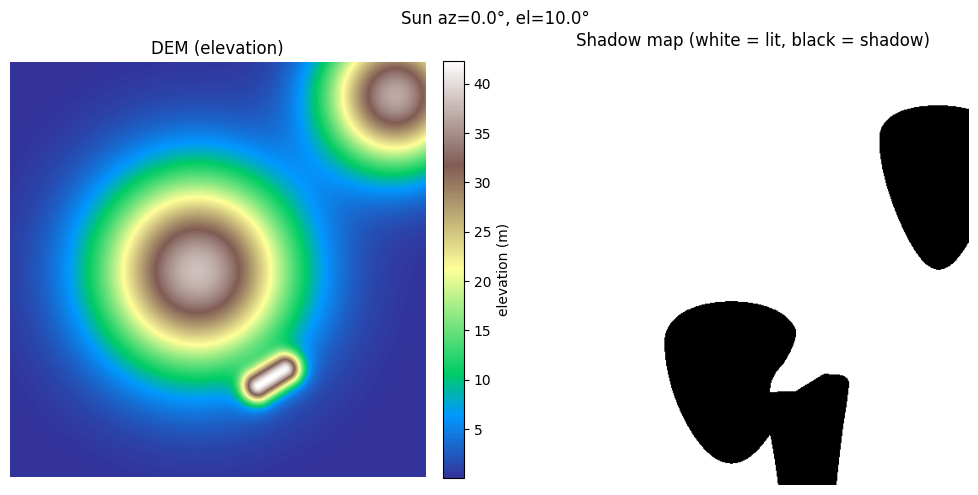

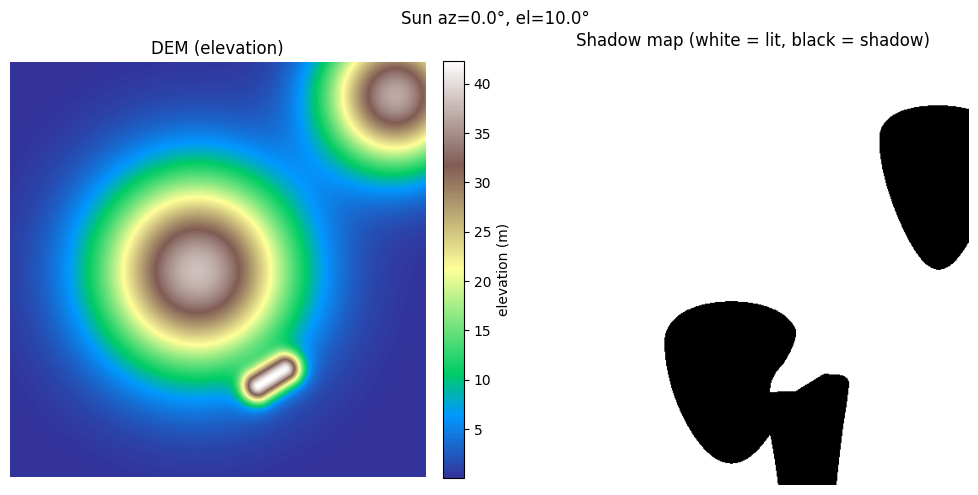

Number of equal pixels between both methods: 262144 / 262144


In [66]:
SUN_AZ = 0.0   # degrees
SUN_EL = 10.0   # degrees

# shadow_map = compute_shadow_map(dem, SUN_AZ, SUN_EL, cellsize=1, upsample = 2, min_component_area=10000)
# shadow_map = compute_shadow_map(dem, SUN_AZ, SUN_EL, cellsize=1, clean = True)
shadow_map = compute_shadow_map(dem, SUN_AZ, SUN_EL, cellsize=1, clean = False, neighborhood_size=6, neighborhood_threshold=0.4)
shadow_map_new = compute_shadow_map_new(dem, SUN_AZ, SUN_EL, cellsize=1)



plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
im = ax1.imshow(dem, cmap='terrain', origin='lower')
ax1.set_title('DEM (elevation)')
ax1.axis('off')
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, label='elevation (m)')

ax2 = plt.subplot(1,2,2)
ax2.imshow(shadow_map, cmap='gray', origin='lower', vmin=0, vmax=1)
ax2.set_title('Shadow map (white = lit, black = shadow)')
ax2.axis('off')

plt.suptitle(f"Sun az={SUN_AZ:.1f}°, el={SUN_EL:.1f}°")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
im = ax1.imshow(dem, cmap='terrain', origin='lower')
ax1.set_title('DEM (elevation)')
ax1.axis('off')
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04, label='elevation (m)')

ax2 = plt.subplot(1,2,2)
ax2.imshow(shadow_map_new, cmap='gray', origin='lower', vmin=0, vmax=1)
ax2.set_title('Shadow map (white = lit, black = shadow)')
ax2.axis('off')

plt.suptitle(f"Sun az={SUN_AZ:.1f}°, el={SUN_EL:.1f}°")
plt.tight_layout()
plt.show()

num_equal_pixels = np.sum(shadow_map == shadow_map_new.numpy())
total_pixels = shadow_map.size
print(f"Number of equal pixels between both methods: {num_equal_pixels} / {total_pixels}")


Image shape: torch.Size([384, 384])
Reflectance map shape: torch.Size([512, 512])


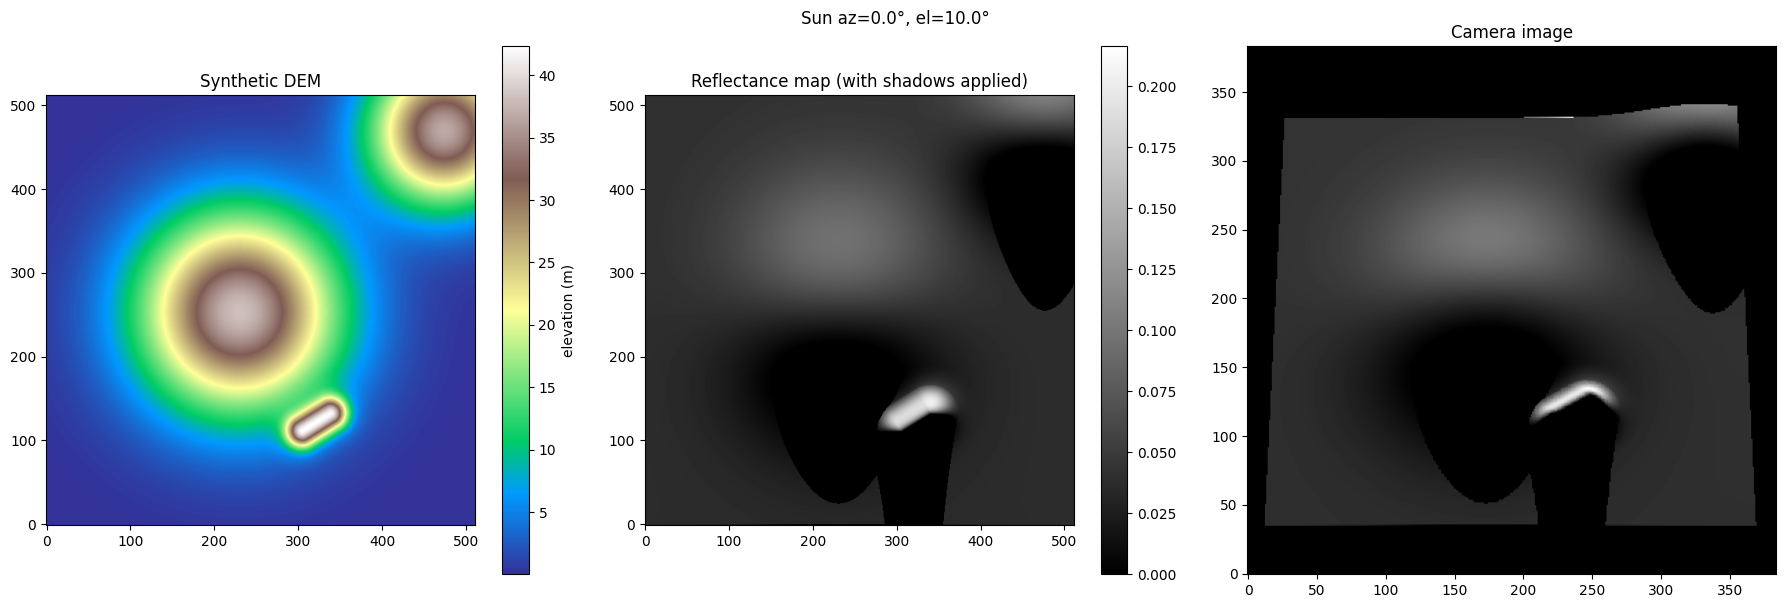

In [64]:
# Render reflectance map and camera image using renderer
# Build objects used by render_single_image


DEM_SIZE = 512
IMAGE_W = 128*3
IMAGE_H = 128*3
FOCAL_LENGTH = 2000.0
SUN_AZ = 0   # degrees
SUN_EL = 10.0   # degrees
CAM_AZ = 180  # degrees
CAM_EL = 60.0   # degrees
CAM_DIST = 3000.0

dem_obj = DEM(dem, cellsize=1, x0=0, y0=0)
hapke = HapkeModel(w=0.6, B0=0.4, h=0.1, phase_fun='hg', xi=0.1)
camera = Camera(image_width=IMAGE_W, image_height=IMAGE_H, focal_length=FOCAL_LENGTH, device='cpu')
renderer = Renderer(dem_obj, hapke, camera)


params = (SUN_AZ, SUN_EL, CAM_AZ, CAM_EL, CAM_DIST)

# render_single_image will compute its own shadow map internally as implemented in the project
img, reflectance_map = _render_single_image(renderer=renderer, params=params, image_w=IMAGE_W, image_h=IMAGE_H)

print('Image shape:', img.shape)
print('Reflectance map shape:', reflectance_map.shape)

# Plot reflectance map and camera image
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(dem, cmap='terrain', origin='lower')
plt.title('Synthetic DEM')
plt.colorbar(label='elevation (m)')

plt.subplot(1,3,2)
plt.imshow(reflectance_map, cmap='gray', origin='lower')
plt.title('Reflectance map (with shadows applied)')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray', origin='lower')
plt.title('Camera image')

plt.suptitle(f"Sun az={SUN_AZ:.1f}°, el={SUN_EL:.1f}°")

plt.tight_layout()
plt.show()
